In [1]:
# for using on colab notebooks
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#!/bin/bash
!kaggle datasets download samuelcortinhas/cats-and-dogs-image-classification

!unzip cats-and-dogs-image-classification.zip

mv: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

train = "/kaggle/input/cats-and-dogs-image-classification/train"
test = "/kaggle/input/cats-and-dogs-image-classification/test"

# Get full paths of files
train_path = [os.path.join(train, f) for f in os.listdir(train) if os.path.isdir(os.path.join(train, f))]
test_path = [os.path.join(test, f) for f in os.listdir(test) if os.path.isdir(os.path.join(test, f))]

print("Files with full paths train:", train_path)
print("Files with full paths test:", test_path)


Files with full paths train: ['/kaggle/input/cats-and-dogs-image-classification/train/dogs', '/kaggle/input/cats-and-dogs-image-classification/train/cats']
Files with full paths test: ['/kaggle/input/cats-and-dogs-image-classification/test/dogs', '/kaggle/input/cats-and-dogs-image-classification/test/cats']


In [2]:
train.split("/")[-2]

'cats-and-dogs-image-classification'

In [3]:
# Implementation of image resizing from scratch was not successful so opencv has been used
def load_data(path):
    labels = []
    data = []
    for category in path:
            
            if category[-4:] == "dogs": #last 4 letters till end of ...cats-and-dogs-image-classification/test/dogs
                
                print(f"No. of images in {category.split('/')[-2]}_{category.split('/')[-1]} is: "+str(len(os.listdir(category)))) # gives number of images for test/train
                
                for image_path in os.listdir(category):
                    image = plt.imread(os.path.join(category,image_path))
                    resized_image = cv2.resize(image, dsize=(200, 200), interpolation=cv2.INTER_NEAREST)
                    data.append(resized_image)
                    labels.append(0)
                    
            elif category[-4:] == "cats": #last 4 letters till end of ...cats-and-dogs-image-classification/test/cats
                
                print(f"No. of images in {category.split('/')[-2]} {category.split('/')[-1]} is: "+str(len(os.listdir(category)))) # gives number of images for test/train
                
                for image_path in os.listdir(category):
                    image = plt.imread(os.path.join(category,image_path))
                    resized_image = cv2.resize(image, dsize=(200, 200), interpolation=cv2.INTER_NEAREST)
                    data.append(resized_image)
                    labels.append(1)
                
    return data, np.array(labels)

In [4]:
train_data, labels_train = load_data(train_path)
test_data, labels_test  = load_data(test_path)

No. of images in train_dogs is: 278
No. of images in train cats is: 279
No. of images in test_dogs is: 70
No. of images in test cats is: 70


In [5]:
labels_train.shape
labels_test.shape

(140,)

In [6]:
labels_train_reshaped = labels_train.reshape((1,labels_train.shape[0])) 
labels_test_reshaped = labels_test.reshape((1,labels_test.shape[0])) 

In [7]:
labels_test_reshaped.shape

(1, 140)

0


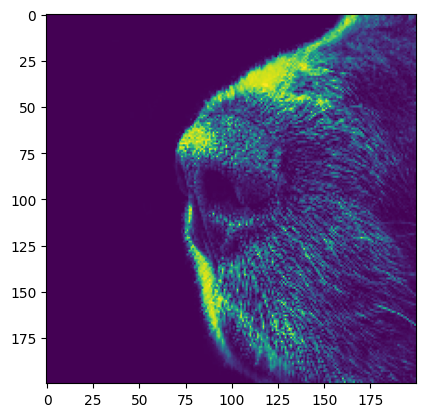

In [8]:
#we are removing one problematic image because some mismatch with colour channel 
plt.imshow(train_data[203])
print(labels_train[203])
train_data.pop(203)
labels_train_reshaped = np.delete(labels_train_reshaped,203)

In [9]:
train_data[203].shape

(200, 200, 3)

In [10]:
train_data = np.array(train_data)

In [11]:
test_data = np.array(test_data)

In [12]:
train_data.shape
test_data.shape

(140, 200, 200, 3)

# #IMAGE Processing Mania 

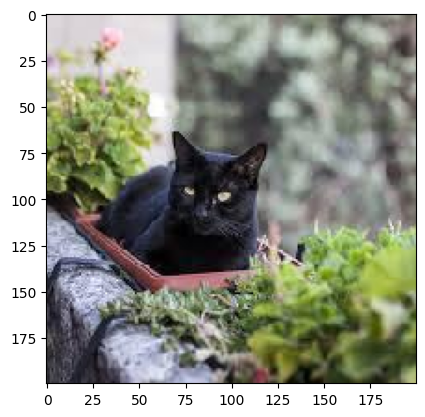

In [13]:
plt.imshow(train_data[555])

In [14]:
#scale down by factor of 2
smaller_img = train_data[0][::2, ::2]

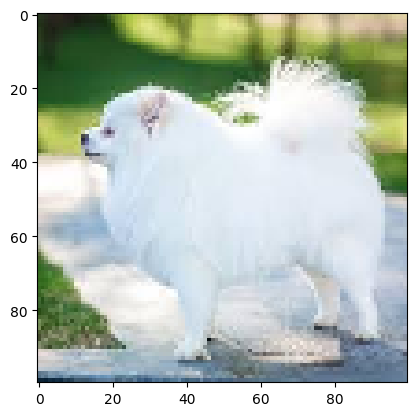

In [15]:
smaller_img.shape
plt.imshow(smaller_img)

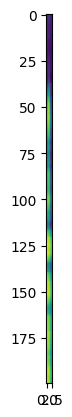

In [16]:
plt.imshow(train_data[0][0])

In [17]:
train_data_flattened = train_data.reshape(train_data.shape[0],-1).T
train_data_flattened.shape

(120000, 556)

In [18]:
test_data_flattened = test_data.reshape(test_data.shape[0],-1).T
test_data_flattened.shape

(120000, 140)

In [19]:
# For picture datasets, it works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel), for standarizing which is a common 
# preprocessing step

train_set_x = train_data_flattened/255
test_set_x = test_data_flattened/255

In [20]:
train_set_x.shape

(120000, 556)

# HERE COMES THE FUN PART> 

In [62]:
# NOW we begin... finally, 
# For implementing logistic regression, we first need some helper functions
import math

def sigmoid(num):
    return 1/(1 + np.exp(-num))

def initializer(dim):
  w = np.zeros((dim,1))
  b = 0
  return w,b

In [22]:
test = initializer(5)
test_wt = np.squeeze(test[0])
test_wt, test[1] 

(array([0., 0., 0., 0., 0.]), 0)

In [23]:
#implementing propagation

def propagate(w, b, X, Y):
    # w , b --> weights, bias (a scalar)
    # X is the training data set (shape: (numx * numy * 3, 1))
    # Y is the array of the true labels (shape: (1,num_sample))

    #a = σ((dot_product(tranpose(w),x) + b)) aka y_hat
    #J(a,y) => -<ylog(a)+(1-y)log(1-a)> ; <> denotes avg
    #z = dot_product(tranpose(w),x) + b
    #x1, w1, w2,x2
    
    '''
    we are going to back propagate to find the derivative dJ/da, dJ/dz..
    dJ/d(var) => d(var) ; we are taking this convention
    
    J(a,y) => -<ylog(a)+(1-y)log(1-a)>
    da = y*1/a + dy/da * log a - (1-y)(1/1-a) - dy/da * log(1-a)
    
    As y (label) is just a const,
        dy/da = 0
    
    da = -y*1/a + (1-y)*(1/1-a)
    
    dz = a - y
    dw1 = x1 * dz
    dw2 = x2 * dz
    dw3 = x3 * dz
    .
    .
    .
    .
    dwi = xi * dz
    db = dz
    
    Now,
    b = b - α*db
    w1 = w1 - α*dw1
    w2 = w2 - α*dw2
    .
    .
    wi = wi - α*dwi

    these steps are vectorized using numpy
    '''

    num_sample = X.shape[1]

    # forward propagation
    A = sigmoid(np.dot(w.T,X) + b) 
    cost = -(np.dot(Y,np.log(A).T) + np.dot((1-Y),np.log(1-A).T))/ num_sample # taking avg value
        
    #back propagation
    dw = np.dot(X, np.subtract(A,Y).T)/ num_sample
    db = np.sum(np.subtract(A,Y))/num_sample

    #Some precautionary code
    assert(dw.shape == w.shape)    #Throw error incase this assertion is false
    assert(db.dtype == float)      
    cost = np.squeeze(cost)        #cost needs to be a number (a value) so it is made sure that any redundant axis that might creep up may be removed
    assert(cost.shape == ())

    return (dw, db, cost)

In [30]:
def optimize(w, b, X_train, Y_train, learning_rate, num_iters ,print_cost=True):
    '''
    here, we update the weights and biasis based on the dw and db. The rate of learning is determined by α (learning rate). If it is too high, the model might never reach
    minimum and if it is too low, it will take many iterations and time to get better.  
    '''
    costs = []
    for i in range(num_iters):
        dw, db, cost = propagate(w, b, X_train, Y_train)
        w -= learning_rate * dw
        b -= learning_rate * db

        #here we note the costs to check in progress of model
        if (i % 100 )== 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:       
            print(f"Cost after {i} iters : {cost} ")
            print("-------------")
    
 

    params = {"w": w, "b": b}
    gradients = {"dw": dw, "db":db}
    
    return params, gradients, costs
        

In [25]:
def predict(w,b,X):
    num_samples = X.shape[1]
    Y_prediction = np.zeros((1,num_samples))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T , X) + b)
    
    Y_prediction = np.where(A[0] < 0.5, 0 ,1)  # vectorized method to give output, if condition is met then 0 else 1
    return Y_prediction 


In [54]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.1,num_iters = 1500, print_cost=True):
    w,b = initializer(X_train.shape[0])
    params, gradient, costs = optimize(w, b, X_train, Y_train, learning_rate=learning_rate,num_iters=num_iters,print_cost=True)

    w, b = params["w"], params["b"]
    Y_predicted_train = predict(w,b,X_train)
    Y_predicted_test = predict(w,b,X_test)

    Test_acc = 100 - np.mean(np.abs(Y_test - Y_predicted_test)*100)
    Train_acc = 100 - np.mean(np.abs(Y_train - Y_predicted_train)*100)

    print(f"Train_acc: {Train_acc} %")
    print(f"Test_acc: {Test_acc} %")
 


    d = {"costs": costs,
         "Y_prediction_test": Y_predicted_test,
         "Y_prediction_train" : Y_predicted_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iters}
    return d

In [70]:
d = model(train_set_x,labels_train_reshaped, test_set_x,labels_test_reshaped, num_iters = 2600, learning_rate = 0.001,print_cost=True)

Cost after 0 iters : 0.6931471805599453 
-------------
Cost after 100 iters : 4.055346628131203 
-------------
Cost after 200 iters : 3.7755781345481663 
-------------
Cost after 300 iters : 3.5416564981371876 
-------------
Cost after 400 iters : 3.33173813852885 
-------------
Cost after 500 iters : 3.147180474784458 
-------------
Cost after 600 iters : 2.983450359053557 
-------------
Cost after 700 iters : 2.829532686229424 
-------------
Cost after 800 iters : 2.6783554959722333 
-------------
Cost after 900 iters : 2.5263085302713417 
-------------
Cost after 1000 iters : 2.3703187615854526 
-------------
Cost after 1100 iters : 2.2078409316979655 
-------------
Cost after 1200 iters : 2.0407384649982414 
-------------
Cost after 1300 iters : 1.8736146393073354 
-------------
Cost after 1400 iters : 1.710120019721514 
-------------
Cost after 1500 iters : 1.554943473545075 
-------------
Cost after 1600 iters : 1.412342112518764 
-------------
Cost after 1700 iters : 1.285330425